In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBBinaryLensing
import sys
sys.path.append("/Users/anything/THU/astro/softwares/aeroastro/gravlen/critical_and_caustics/pys")
from utils import *

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

In [2]:
# Initialize VBBinaryLensing() class object, set relative accuracy
VBBL = VBBinaryLensing.VBBinaryLensing()
VBBL.RelTol = 1e-03

In [291]:
t  =  np.linspace(7000, 7300, 500)

s = 1 # separation between the two lenses in units of total ang. Einstein radii
q = 0.5 # mass ratio: mass of the lens on the right divided by mass of the lens on the left
rho = 0.01 # source radius in Einstein radii of the total mass.
alpha = 0.93 # angle between lens axis and source trajectory
tE = 100.3 # einstein radius crossing time
t0 = 7154. # time of peak magnification
u0 = 0.3 # impact parameter

# Position of the center of the source with respect to the center of mass.
tau = (t - t0)/tE

# VBBinaryLensingLibrary.cpp
# 		y1s[i] = pr[2] * salpha - tn*calpha;
# 		y2s[i] = -pr[2] * calpha - tn*salpha;
# tn = (ts[i] - pr[6]) * tE_inv;

# tau = (t - t0)/tE
# y1s[i] = u0*sin(alpha) - tau*cos(alpha)
# y2s[i] = -u0*cos(alpha) - tau*sin(alpha)

# so, this is wrong since the cpp source have this two lines:
y1 = -u0*np.sin(alpha) + tau*np.cos(alpha)
y2 = u0*np.cos(alpha) + tau*np.sin(alpha)

y1_me = u0*np.sin(alpha) - tau*np.cos(alpha)
y2_me = -u0*np.cos(alpha) - tau*np.sin(alpha)


mag = np.zeros(len(tau))

# Calculate the magnification at each time 
#?VBBL.BinaryLightCurve

params = [np.log(s), np.log(q), u0, alpha, np.log(rho), np.log(tE), t0]
mag = VBBL.BinaryLightCurve(params, t, y1, y2)
#VBBL.BinaryLightCurve called BinaryMag2(s, q, y1s[i], y2s[i], rho)

In [292]:
# Calculate the cirtical curves and the caustic curves
solutions = VBBL.PlotCrit(s, q) # Returns _sols object containing n crit. curves followed by n caustic curves
print(type(solutions))

<class 'VBBinaryLensing._sols'>


In [293]:
# generator function iterating over _sols, _curve, or _point objects 
# making use of the next keyword
def iterate_from(item):
    while item is not None:
        yield item
        item = item.next

curves = []
for curve in iterate_from(solutions.first):
    for point in iterate_from(curve.first):
        curves.append((point.x1, point.x2))
        
critical_curves = np.array(curves[:int(len(curves)/2)])
caustic_curves = np.array(curves[int(len(curves)/2):])

(-1, 1)

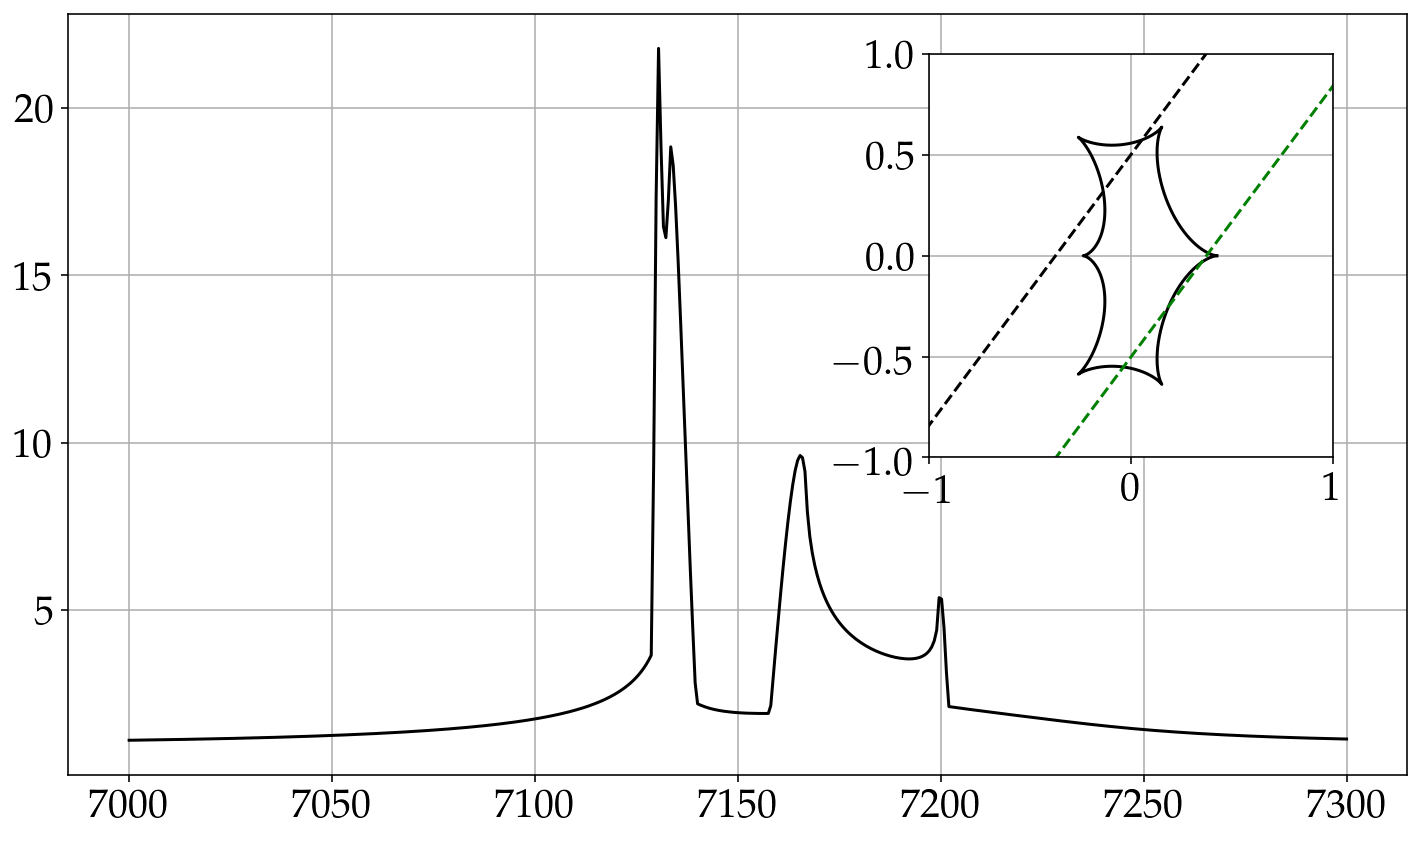

In [294]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(t, mag, 'k-')
ax.grid(True)

ax2 = fig.add_axes([.54, .44, .4, .4], aspect=1)
ax2.plot(caustic_curves[:, 0], caustic_curves[:, 1], 'k-')
ax2.plot(y1, y2, 'k--')
ax2.plot(y1_me, y2_me, 'g--')
ax2.grid(True)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)

In [295]:
idx = 15
# Mag = VBBL.BinaryMag2(s, q, y1_me[idx], y2_me[idx], rho)
Mag = VBBL.BinaryMag0(s, q, y1[idx], y2[idx])
print(Mag, mag[idx]) #1.1184850824283166 1.118485082428317
# Now is ok, using VBBL.BinaryMag2 can easily compute the Magnification
# at certain position (y1, y2)
# Then the magnification map can easily computed, just take the magnification
# value of a pixel's centre as the value of the pixel

1.1283942107497098 1.1164660398767146


In [304]:
xlim, ylim = (-2,2), (-2,2)
num = 2048
datatype = np.float32

ImgSize = (num, num)
thetax, thetay = genxy(xlim=xlim,ylim=ylim,num=num, datatype = datatype)
srcplanemag = np.zeros(thetax.shape)
srcplaneIMG = np.zeros(ImgSize).astype(datatype)

from tqdm import tqdm
with tqdm(total=len(thetax)) as pbar:
    for idx in range(len(thetax)):
        srcplanemag[idx] = VBBL.BinaryMag2(s, q, thetax[idx], thetay[idx], rho)
#         srcplanemag[idx] = VBBL.BinaryMag0(s, q, thetax[idx], thetay[idx]) #point source
        pbar.update(1)
srcplaneIMG = srcplanemag.reshape(ImgSize)

100%|██████████| 4194304/4194304 [00:38<00:00, 109481.55it/s]


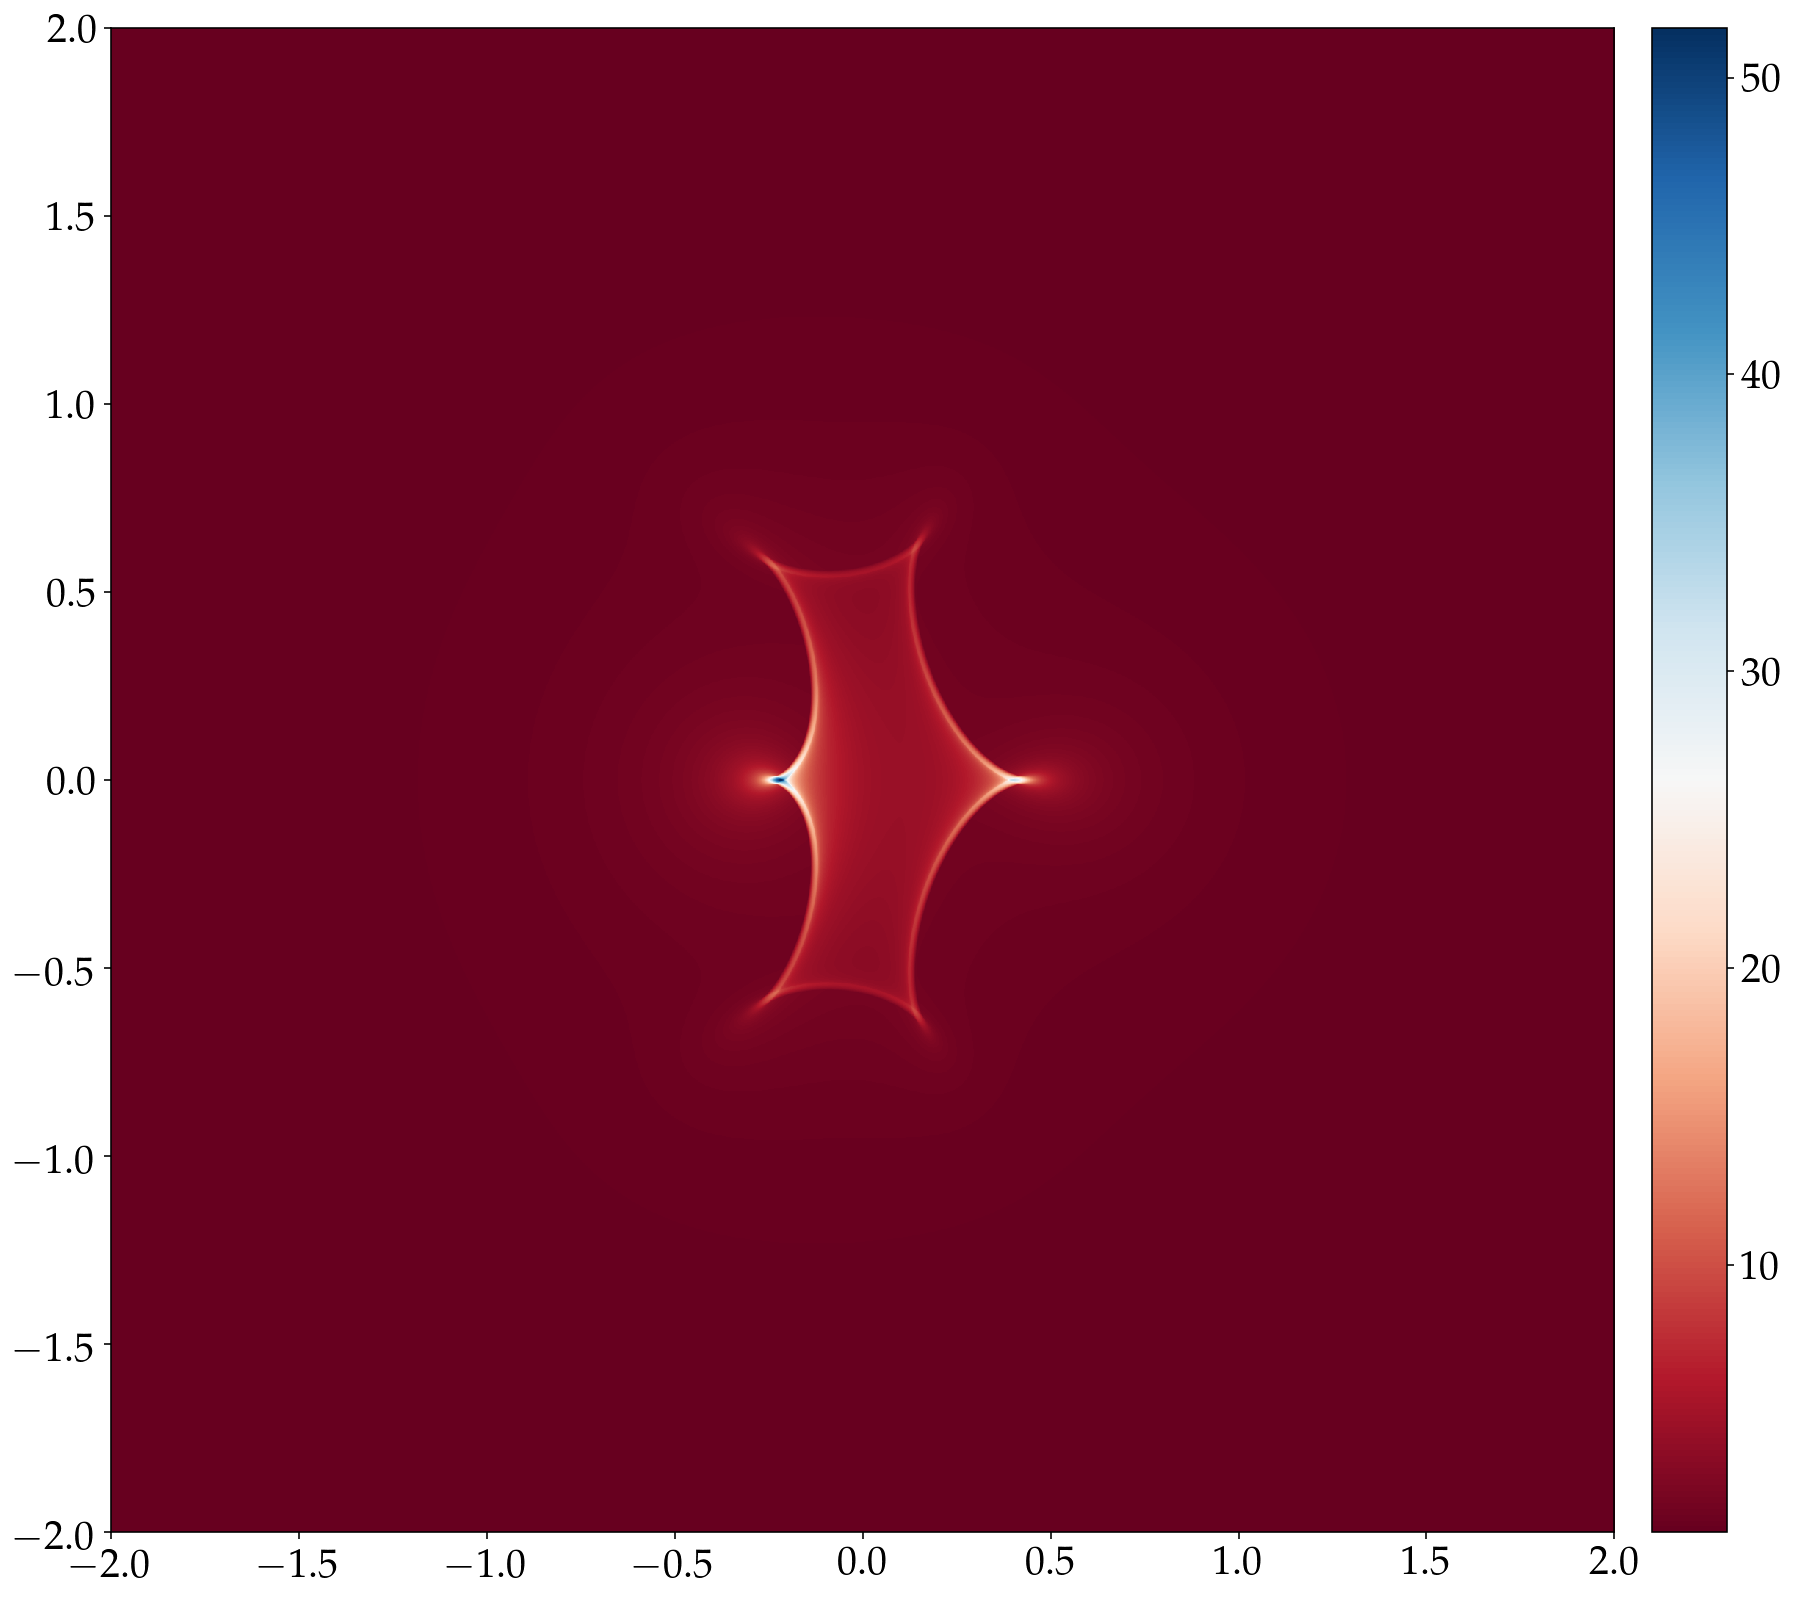

In [305]:
cmap = plt.cm.get_cmap('RdBu')#viridis, inferno, jet, RdBu, Blues
fig3 = plt.figure()
fig3.set_size_inches(20,12)
plt.subplots_adjust(left=0.04, top = 0.92, bottom = 0.05, right=0.96, hspace = 0, wspace = 0)
plt.margins(0,0)
fig3img = plt.imshow(srcplaneIMG,origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig3img)
plt.show()

In [306]:
# magnification map using inverse ray shooting
# srcplaneIMG, imgplaneIMG, srcplaneIMG_withoutlens = twolens.get_imgs_lessmem_v2(ImgSize, xlim, ylim, num, datatype = np.float64)
from totahiti191210.two_pmnegq_inverse_ray_shoot_191210 import *

In [316]:
# xs = np.array([-s, 0])

# Actually the origin is taken at the centre of two point mass:
xs = np.array([-q/(1+q), 1/(1+q)])*s
ys = np.array([0,0])
raynum = 20000
masses = np.array([1/(1+q),q/(1+q)]) # smaller mass is at origin
twolens = Nlenses(masses, xs, ys)

In [317]:
# finite source size
# 0.01/4*2048
psfsize = int(rho/(xlim[1]-xlim[0])*ImgSize[0])
psf = np.zeros((psfsize, psfsize))
for ir in range(psfsize):
    for ic in range(psfsize):
        if ir**2+ic**2<=psfsize**2:
            psf[ir,ic]=1
psf/=np.sum(psf)
from scipy import signal
# c_full = signal.convolve2d(I,Kernel,mode='full')

In [318]:
# srcplaneIMG_rayshoot, _, _ = twolens.get_imgs_lessmem_v2(ImgSize, xlim, ylim, raynum, datatype = datatype)

In [319]:
# fig2 = plt.figure()
# fig2.set_size_inches(20,12)
# plt.subplots_adjust(left=0.04, top = 0.92, bottom = 0.05, right=0.96, hspace = 0, wspace = 0)
# plt.margins(0,0)
# fig2img = plt.imshow(np.log10(srcplaneIMG_rayshoot),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
# add_colorbar(fig2img)
# plt.show()

In [ ]:
srcplaneIMG_rayshootNomag, _, _ = twolens.get_imgs_lessmem_v3(ImgSize, xlim, ylim, raynum, datatype = datatype)

 23%|██▎       | 4502/20000 [19:59<1:05:23,  3.95it/s]

In [ ]:
srcplaneIMG_rayshootNomag_psf = signal.convolve2d(srcplaneIMG_rayshootNomag,psf,mode='same')
# srcplaneIMG_rayshootNomag_psf = srcplaneIMG_rayshootNomag # point source

In [ ]:
fig1 = plt.figure()
fig1.set_size_inches(20,12)
plt.subplots_adjust(left=0.04, top = 0.92, bottom = 0.05, right=0.96, hspace = 0, wspace = 0)
plt.margins(0,0)
fig1img = plt.imshow((srcplaneIMG_rayshootNomag_psf),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig1img)
plt.show()

In [ ]:
# see the difference between inverse ray shooting and Bozza's method:
diffimg = srcplaneIMG_rayshootNomag_psf - srcplaneIMG

fig0 = plt.figure()
fig0.set_size_inches(20,12)
plt.subplots_adjust(left=0.04, top = 0.92, bottom = 0.05, right=0.96, hspace = 0, wspace = 0)
plt.margins(0,0)
fig0img = plt.imshow((diffimg),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig0img)
plt.show()

In [ ]:
# cmap = plt.cm.get_cmap('jet')#viridis, inferno
fig = plt.figure()
fig.set_size_inches(36,12)
plt.subplots_adjust(left=0.04, top = 0.92, bottom = 0.05, right=0.96, hspace = 0.2, wspace = 0.2)
plt.margins(0,0)
title_fs="Magnification map of Bozza's (left) and Ray Shooting (mid) method and their difference (right) for \n"+r"s = {:.2f}, q = {:.2f}, $\rho = ${:.3f}".format(s,q,rho)
# title_ps="Magnification map of Bozza's (left) and Ray Shooting (mid) method and their difference (right) for \n"+r"s = {:.2f}, q = {:.2f}, $\rho = ${:.3f}".format(s,q,rho)
plt.suptitle(title_fs,fontsize=40)
plt.subplot(131)
fig0img = plt.imshow((srcplaneIMG),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig0img)
plt.subplot(132)
fig0img = plt.imshow((srcplaneIMG_rayshootNomag_psf),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig0img)
plt.subplot(133)
fig0img = plt.imshow((diffimg),origin='lower',cmap=cmap, extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
add_colorbar(fig0img)

plt.show()

In [ ]:
# fig.savefig(title.replace(" ","").replace("\n","")+".png", format='png', bbox_inches='tight', dpi=300, pad_inches = 0)